In [1]:
import sys, importlib, time
sys.path.append('../../')

from src.Modules.Utils.Imports import *
device = torch.device(GetLowestGPU(pick_from=[0]))

import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import DE_sim
from src.get_params import get_adhesion_params_Pm_Padh_interpolation
import numpy.matlib as matlib
from scipy.interpolate import RBFInterpolator
from src.custom_functions import to_torch, to_numpy, load_model, recover_binn_params, unique_inputs, MSE

### Params for plotting
fontsize=24
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Data specifications
path = '../../data/'
filename_header = "simple_adhesion_mean_25"

### BINN model information
save_folder = "../../results/weights/"
model_name = 'DMLP'
weight = '_best_val'
pde_weight = 1e4

def BINN_diffusion_mesh(T_mesh,params):
    
    """
    Compute diffusion coefficients for a density mesh and parameter values.

    Parameters:
        T_mesh (np.ndarray): A mesh of density values.
        params (tuple): Model parameters, including Adhesion agentmigration `rmh`
                        and adhesion strength `Padh`.

    Returns:
        np.ndarray: Diffusion coefficients computed for the T_mesh and the given params
    """
    
    rmh, Padh = params
    file_name = f'{filename_header}_Pm_{rmh}_Padh_{Padh}'    

    binn_name  = f"{model_name}"
    save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
    model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=1.0,t=1.0)

    D_mesh = to_numpy(binn.diffusion(to_torch(T_mesh)[:, None]))
    
    return D_mesh

def simulate_interpolant_PDE(params,f):

    """
    Simulate a PDE with interpolated diffusion coefficients based on 
    given parameters and and interpolant, f.

    Parameters:
        params (tuple or float): Model parameters, including Adhesion agentmigration `rmh`
                        and adhesion strength `Padh`.
        f (callable): A function that provides interpolated diffusion coefficients based on time and parameters.

    Returns:
        np.ndarray: Spatial grid points `x`.
        np.ndarray: Time points `t`.
        np.ndarray: The solution of the PDE system with interpolated diffusion.
        np.ndarray: The original data for comparison.
    """
    
    if len(params)==1: #only changing Padh
        rmh = 1.0
        Padh = params[0]
    else: #changing rmh and Padh
        rmh, Padh = params
    
    #Define function of T for numerical integration
    def interpolated_diffusion(T):
        
        ### Create [T;params]
        param_mesh = matlib.repmat(params,len(T),1)
        sampled_points_mesh = np.hstack([T[:,None], param_mesh])
        ### Compute D(T;params)
        D_mesh = f(sampled_points_mesh)
        ### Set negative values to zero
        D_mesh[D_mesh < 0] = 0
        
        return D_mesh

    ### Load in ABM data
    file_name = f'{filename_header}_Pm_{rmh}_Padh_{Padh}' 
    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
    x,t = unique_inputs(inputs)
    U = outputs.reshape((len(x),-1))
    #Use first timeshot for initial condition
    IC = U[:,0]
    
    sol = DE_sim(x, 
                 t, 
                 [], 
                 IC, 
                 Diffusion_function = interpolated_diffusion)
    
    return x, t, sol, U
    
def MSE_computation(params, f):
    
    """
    Compute Mean Squared Error (MSE) for training and testing data in 
    predicting ABM data with interpolated PDE simulations
    
    Parameters:
        params (tuple or float): Model parameters, including Adhesion agent migration `rmh`
                        and adhesion strength `Padh`.
        f (callable): A function that provides interpolated diffusion coefficients based on time and parameters.

    Returns:
        MSE_train (float): MSE for the training data.
        MSE_test  (float): MSE for the testing data.
    """
    
    x, t, sol, U = simulate_interpolant_PDE(params,f)

    t_max = np.max(t)
    t_perc = 0.75
    
    U_train = U[:,t<=t_perc*t_max]
    U_test  = U[:,t >t_perc*t_max]
    
    sol_train = sol[:,t<=t_perc*t_max]
    sol_test  = sol[:,t >t_perc*t_max]
    
    MSE_train =  MSE(sol_train, U_train)
    MSE_test = MSE(sol_test, U_test)
    
    return MSE_train, MSE_test

/home/hpc/nardinij/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Device set to cpu
Device set to cpu


## Predicting Adhesion ABM with rmh fixed

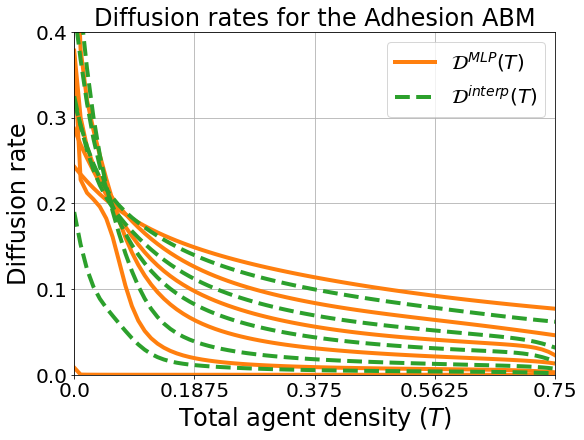

In [4]:
#Specify parameters
rmh = 1.0
rmh_new = 1.0
Padhs = np.array([.5, .6, .7, .8, .9, 1.0])
Padhs_new = np.array([.55, .65, .75, .85, .95])

#group old and new parameters
params_old = np.hstack( (rmh*np.ones((len(Padhs),1)),     Padhs[:,None]) )
params_new = np.hstack( (rmh*np.ones((len(Padhs_new),1)), Padhs_new[:,None]) )

#dependent variable
T_mesh = np.linspace(0, 1, 101)[:,None]

### Create inputs (sampled_points = [T;params]) and outputs (D(T;params)) for prior dataset
count = 0
for params in params_old:
    
    rmh, Padh = params
    
    D_mesh_tmp = BINN_diffusion_mesh(T_mesh, params)

    param_mesh_tmp = matlib.repmat(Padh,len(T_mesh),1)
    sampled_points_mesh_tmp = np.hstack([T_mesh, param_mesh_tmp])
    
    if count == 0:
        D_mesh = D_mesh_tmp
        sampled_points = sampled_points_mesh_tmp 
    else:
        D_mesh = np.vstack([D_mesh,D_mesh_tmp])
        sampled_points = np.vstack([sampled_points,sampled_points_mesh_tmp])
    count+=1 
D_mesh = np.squeeze(D_mesh)   
### interpolator matches [T;params] -> D(T;params)
f = RBFInterpolator(sampled_points, D_mesh)
### reshape D to be D(T; params)
D_mesh = D_mesh.reshape((-1,len(T_mesh))).T

### Create inputs (sampled_points = [T;params]) for new dataset
count = 0    
for params in params_new:
    
    rmh, Padh = params
    
    param_mesh_tmp = matlib.repmat(Padh,len(T_mesh),1)
    sampled_points_mesh_tmp = np.hstack([T_mesh, param_mesh_tmp])
    
    if count == 0:
        sampled_points_new = sampled_points_mesh_tmp 
    else:
        sampled_points_new = np.vstack([sampled_points_new,sampled_points_mesh_tmp])
    count+=1 

### Estimate D at new parameter values
D_mesh_new = f(sampled_points_new)
D_mesh_new = D_mesh_new.reshape((-1,len(T_mesh))).T

### Save to file
data = {}
data['f'] = f
np.save("../../results/PDE_sims/adhesion_interpolant_rmh_fixed.npy",data)

### Plot results
fig, ax = plt.subplots(1,1,figsize=(8,6),layout="constrained")

count = 0
for Padh in Padhs:
    label = "$\mathcal{D}^{MLP}(T)$" if count==0 else ""
    ax.plot(T_mesh, D_mesh[:,count], color=colors[1],linewidth=4, label=label)
    count+=1

count = 0
for Padh in Padhs_new:
    label = "$\mathcal{D}^{interp}(T)$" if count==0 else ""    
    ax.plot(T_mesh, D_mesh_new[:,count], "--",linewidth=4, color = colors[2], label=label)
    count+=1

ax.set_xlim([0,0.75])
ax.set_ylim([0,0.4])

ax.set_xlabel("Total agent density ($T$)",fontsize=fontsize)
ax.set_ylabel("Diffusion rate",fontsize=fontsize)
ax.set_title("Diffusion rates for the Adhesion ABM",fontsize=fontsize)

plt.xticks([0, 0.375/2, 0.375, 0.375*3/2,  0.75], labels = np.round([0, 0.375/2, 0.375, 0.375*3/2,  0.75],4), fontsize=20)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4],fontsize=20)

plt.grid()
plt.legend(fontsize=20)

plt.savefig(f"../../results/figures/Adhesion_Interpolated_diffusion_rates_rmh_fixed.png",format="png") 

## Predict new data, compute MSE values

0.55
0.65
0.75
0.85
0.95
0.5
0.6
0.7
0.8
0.9
1.0


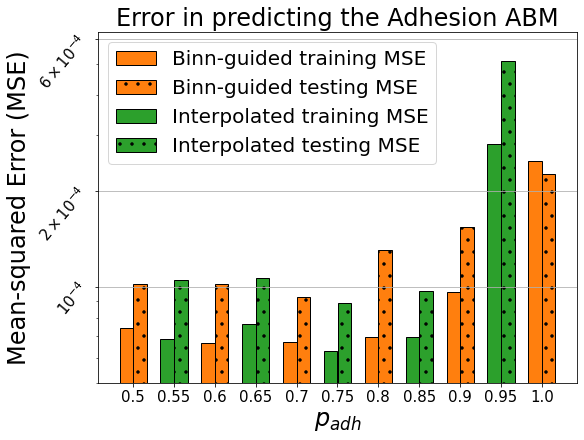

In [3]:
### Initialize MSEs
interpolated_sol_MSEs_train_new = []
interpolated_sol_MSEs_test_new = []

for Padh in Padhs_new:
    
    print(Padh)
    
    ### Compute MSEs
    MSE_train, MSE_test = MSE_computation((Padh,), f)
    
    ### Save
    interpolated_sol_MSEs_train_new.append(MSE_train)
    interpolated_sol_MSEs_test_new.append(MSE_test)

#convert to ndarray
interpolated_sol_MSEs_train_new = np.array(interpolated_sol_MSEs_train_new)
interpolated_sol_MSEs_test_new = np.array(interpolated_sol_MSEs_test_new)

### Also compute old MSE values
interpolated_sol_MSEs_train_old = []
interpolated_sol_MSEs_test_old = []
for Padh in Padhs:
    
    print(Padh)
    
    MSE_train, MSE_test = MSE_computation((Padh,), f)

    interpolated_sol_MSEs_train_old.append(MSE_train)
    interpolated_sol_MSEs_test_old.append(MSE_test)

### convert to ndarray
interpolated_sol_MSEs_train_old = np.array(interpolated_sol_MSEs_train_old)
interpolated_sol_MSEs_test_old = np.array(interpolated_sol_MSEs_test_old)

### plot
plt.figure(figsize=(8,6),layout="constrained")

### Combine old and new data into one array
MSE_trains = np.zeros((len(interpolated_sol_MSEs_train_new)+len(interpolated_sol_MSEs_train_old)))
MSE_tests = np.zeros(MSE_trains.shape)
Padhs_all = np.zeros(MSE_trains.shape)
# even entries are old data
MSE_trains[::2] = interpolated_sol_MSEs_train_old
MSE_tests[::2] = interpolated_sol_MSEs_test_old
Padhs_all[::2] = Padhs
# odd entries are old data
MSE_trains[1::2] = interpolated_sol_MSEs_train_new
MSE_tests[1::2] = interpolated_sol_MSEs_test_new
Padhs_all[1::2] = Padhs_new

N = len(interpolated_sol_MSEs_train_old)
plt.bar(np.arange(0,2*N,2)-.167, interpolated_sol_MSEs_train_old,color = colors[1], width = 0.33, log = True, edgecolor="k", label = "Binn-guided training MSE")
plt.bar(np.arange(0,2*N,2)+.167, interpolated_sol_MSEs_test_old,color = colors[1], width = 0.33, log = True, edgecolor="k", hatch=".", label = "Binn-guided testing MSE")

plt.bar(np.arange(1,2*N-1,2)-.167, interpolated_sol_MSEs_train_new,color = colors[2], width = 0.33, log = True, edgecolor="k", label = "Interpolated training MSE")
plt.bar(np.arange(1,2*N-1,2)+.167, interpolated_sol_MSEs_test_new,color = colors[2], width = 0.33, log = True, edgecolor="k", hatch=".", label = "Interpolated testing MSE")

xlabels = [f"{round(.5+i*.05,2)}" for i in np.arange(11)]
plt.xticks(np.arange(11), labels = xlabels, rotation = 0, fontsize=15)
plt.yticks([1e-4, 2e-4, 6e-4],labels = ["$10^{-4}$", r"$2\times10^{-4}$", r"$6\times10^{-4}$"],fontsize=15, rotation=50)

plt.xlabel("$p_{adh}$",fontsize=fontsize)
plt.ylabel("Mean-squared Error (MSE)",fontsize=fontsize)
plt.title("Error in predicting the Adhesion ABM",fontsize=fontsize)
plt.legend(fontsize=20)
plt.grid(axis="y")
plt.ylim([5e-5,6.3e-4])
plt.savefig(f"../../results/figures/Adhesion_Interpolation_error_fixed_rmh.png",format="png")

## Interpolation along Padh and rmh

In [6]:
### get parameters
params_old = get_adhesion_params_Pm_Padh_interpolation("old")
params_new = get_adhesion_params_Pm_Padh_interpolation("new")

T_mesh = np.linspace(0, 1, 101)[:,None]

### Create inputs (sampled_points = [T;params]) and outputs (D(T; params)) for prior dataset
count = 0
for params in params_old:
    
    D_mesh_tmp = BINN_diffusion_mesh(T_mesh, params)

    param_mesh_tmp = matlib.repmat(params,len(T_mesh),1)
    sampled_points_mesh_tmp = np.hstack([T_mesh, param_mesh_tmp])
    
    if count == 0:
        D_mesh = D_mesh_tmp
        sampled_points = sampled_points_mesh_tmp 
    else:
        D_mesh = np.vstack([D_mesh,D_mesh_tmp])
        sampled_points = np.vstack([sampled_points,sampled_points_mesh_tmp])
    count+=1 

D_mesh = np.squeeze(D_mesh)
### Perform interpolation
f = RBFInterpolator(sampled_points, D_mesh.reshape(-1), kernel="linear")
 
### Create inputs (sampled_points = [T;params]) for new dataset
count = 0    
for params in params_new:
    
    param_mesh_tmp = matlib.repmat(params,len(T_mesh),1)
    sampled_points_mesh_tmp = np.hstack([T_mesh, param_mesh_tmp])
    
    if count == 0:
        sampled_points_new = sampled_points_mesh_tmp 
    else:
        sampled_points_new = np.vstack([sampled_points_new,sampled_points_mesh_tmp])
    count+=1     


### Save to file
data = {}
data['f'] = f
np.save("../../results/PDE_sims/adhesion_interpolant.npy",data)


### Compute MSEs on new dataset
interpolated_sol_MSEs_train_new = []
interpolated_sol_MSEs_test_new = []

for params in params_new:
    
    MSE_train, MSE_test = MSE_computation(params, f)

    interpolated_sol_MSEs_train_new.append(MSE_train)
    interpolated_sol_MSEs_test_new.append(MSE_test)

interpolated_sol_MSEs_train_new = np.array(interpolated_sol_MSEs_train_new)
interpolated_sol_MSEs_test_new = np.array(interpolated_sol_MSEs_test_new)

#Sort by increasing training MSE values
MSE_sort_index = np.argsort(interpolated_sol_MSEs_train_new)

### plot
plt.figure(figsize=(8,6),layout="constrained")

N = len(interpolated_sol_MSEs_train_new)
plt.bar(np.arange(N), interpolated_sol_MSEs_train_new[MSE_sort_index],color = colors[2], width = 0.33, log = True, label = "Interpolated training MSE", edgecolor="k")
plt.bar(np.arange(N)+.33, interpolated_sol_MSEs_test_new[MSE_sort_index],color = colors[2], width = 0.33, log = True, label = "Interpolated testing MSE", hatch = ".", edgecolor="k")

xlabels = [f"{i}" for i in np.arange(1,N+1)]
plt.xticks(np.arange(N)+.167, labels = xlabels, rotation = 0, fontsize=15)
plt.yticks([1e-4, 2e-4, 1e-3],labels = ["$10^{-4}$", r"$2\times10^{-4}$", "$10^{-3}$"],fontsize=15, rotation=50)

plt.grid(axis="y", linewidth=0.25)

plt.xlabel("LHC samples", fontsize=fontsize)
plt.ylabel("Mean-squared error (MSE)", fontsize=fontsize)
plt.title("Error in predicting the Adhesion ABM", fontsize=fontsize)

plt.legend(fontsize=20)
plt.savefig("../../results/figures/adhesion_interpolation.pdf",format="pdf")

NameError: name 'MSE_computation' is not defined

### Plot parameters

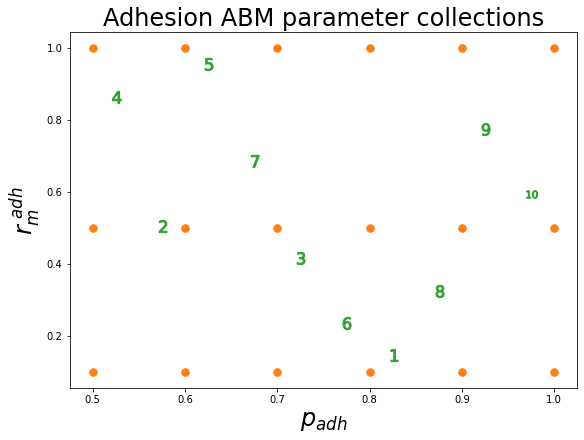

In [38]:
plt.figure(figsize=(8,6),layout="constrained")
rmhs = [0.1, 0.5, 1.0]
Padhs = [.5,.6,.7,.8,.9,1.0]
count = 0
for rmh in rmhs:
    for Padh in Padhs:
        if count == 0:
            label = "$\mathcal{P}^{prior}$"
        else:
            label = ""
        plt.plot(Padh,rmh,".",c=colors[1],markersize=15,label=label)
        count+=1

count = 0
for ii in MSE_sort_index:
    if count == 0:
            label = "$\mathcal{P}^{new}$"
    else:
        label = ""
    rmh,Padh = params_new[ii]
    plt.scatter(Padh,rmh,c=colors[2],marker=f"${count+1}$",s=150,label=label)
    count+=1

plt.xlabel("$p_{adh}$",fontsize=fontsize)
plt.ylabel("$r_m^{\ adh}$",fontsize=fontsize)
#plt.legend(fontsize=fontsize)
plt.title("Adhesion ABM parameter collections",fontsize=fontsize)
plt.savefig(f"../../results/figures/Adhesion_sample_locations_Padh_and_rmh.png",format="png")

## Plot 3 example diffusion rates

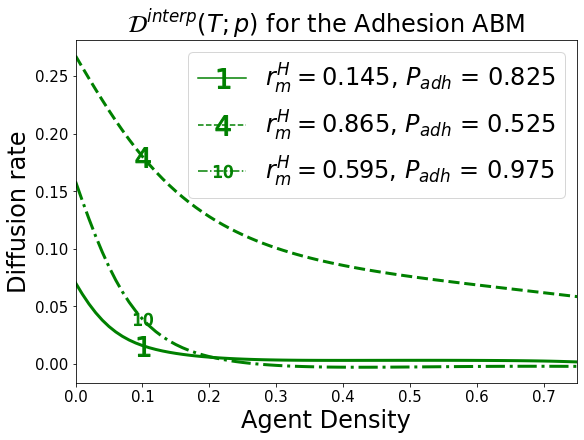

In [40]:
fontsize=24
plt.figure(figsize=(8,6),layout="constrained")
count = 0
lines = ["-","--","-."]
for i in [0, 3, 9]:
    index = MSE_sort_index[i]
    rmh,Padh = params_new[index]
    T = np.linspace(0,1,101)

    param_mesh = matlib.repmat((rmh,Padh),len(T),1)
    sampled_points_mesh = np.hstack([T[:,None], param_mesh])
    D_mesh_new = f(sampled_points_mesh)

    padh_str = ""
    plt.plot(T,D_mesh_new,color="g",linestyle=lines[count], linewidth=3, markersize=15)
    plt.plot(T[10],D_mesh_new[10],color="g",marker=f"${i+1}$",linestyle=lines[count],markersize=20,label=f"$r_m^H = ${rmh}, "+"$P_{adh}$ = "+f"{Padh}")
    count+=1
    
plt.xlim([0,0.75])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=fontsize)
plt.xlabel("Agent Density",fontsize=fontsize)
plt.ylabel("Diffusion rate",fontsize=fontsize)
plt.title(r"$\mathcal{D}^{interp}(T; p)$ for the Adhesion ABM",fontsize=fontsize)

plt.savefig("../../results/figures/adhesion_interpolation_diffusion_rates.pdf",format="pdf")

## Make table of samples

In [12]:
print("    \centering")
print(r"    \begin{tabular}{|c|c|}")
print("    \hline")
print("    Sample &   \\Pm = $(r_m^{adh},\ {p_{adh}})^T$ \\\\ \\hline")
for i in np.arange(len(MSE_sort_index)):
    index = MSE_sort_index[i]
    rmh,Padh = rmhs_new[index], Padhs_new[index]
    print(f"    {i+1} &   ({rmh}, {Padh})$^T$ \\\\ \\hline")
print("    \end{tabular}")    

    \centering
    \begin{tabular}{|c|c|}
    \hline
    Sample &   \Pm = $(r_m^{adh},\ {p_{adh}})^T$ \\ \hline
    1 &   (0.145, 0.825)$^T$ \\ \hline
    2 &   (0.505, 0.575)$^T$ \\ \hline
    3 &   (0.415, 0.725)$^T$ \\ \hline
    4 &   (0.865, 0.525)$^T$ \\ \hline
    5 &   (0.955, 0.625)$^T$ \\ \hline
    6 &   (0.235, 0.775)$^T$ \\ \hline
    7 &   (0.685, 0.675)$^T$ \\ \hline
    8 &   (0.325, 0.875)$^T$ \\ \hline
    9 &   (0.775, 0.925)$^T$ \\ \hline
    10 &   (0.595, 0.975)$^T$ \\ \hline
    \end{tabular}
